### import modules

In [66]:
import sklearn
import shap
import pickle
import datetime
import pprint
import pandas as pd
import numpy as np
import xgboost as xgb

from matplotlib import pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

pd.set_option('display.max_rows', 10)

### load data

In [73]:
user_visits = pd.read_csv('takehome_user_engagement-intern.csv')
users = pd.read_csv('takehome_users-intern.csv', encoding='latin-1')
users.rename(columns={'object_id': 'user_id'}, inplace=True)
users['invited_by_user'] = users['invited_by_user_id'].apply(lambda x: 0 if pd.isna(x) else 1).astype('bool')
user_invite_counts = users['invited_by_user_id'].value_counts()
users['num_users_invited'] = users['user_id'].apply(lambda x: user_invite_counts[x] if x in user_invite_counts else 0)
users

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,email_domain,invited_by_user,num_users_invited
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,yahoo.com,True,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,gustr.com,True,0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,gustr.com,True,1
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,yahoo.com,True,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,yahoo.com,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0,gustr.com,True,0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,NaN,gmail.com,False,1
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0,cuvox.de,True,0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,NaN,iuxiw.com,False,7


### get adpoted users

In [74]:
user_visits['time_stamp'] = pd.to_datetime(user_visits['time_stamp'])
user_visits = user_visits.drop('visited', axis=1)
user_visits = user_visits.groupby('user_id').agg(lambda timestamps: [ts for ts in timestamps])

def get_time_diffs(timestamps):
    if len(timestamps) > 1:
        for i in reversed(range(1, len(timestamps))):
            timestamps[i] = timestamps[i] - timestamps[i-1]
    timestamps[0] = datetime.timedelta()
    return timestamps

def check_adopted(time_diffs):
    if len(time_diffs) < 3:
        return False
    for i in range(2, len(time_diffs)):
        if time_diffs[i] + time_diffs[i-1] < datetime.timedelta(days=7):
            return True
    return False


user_visits['time_diffs'] = user_visits['time_stamp']
user_visits['time_diffs'] = user_visits['time_diffs'].apply(lambda x: get_time_diffs(x))
user_visits['adopted'] = user_visits['time_diffs'].apply(lambda x: check_adopted(x))
users_adopted = user_visits.drop(['time_diffs', 'time_stamp'], axis=1)
users_adopted

,adopted
user_id,
1,False
2,True
3,False
4,False
5,False
...,...
11996,False
11997,False
11998,False


### create user feature data

In [75]:
users = users.join(users_adopted, on='user_id')
users = users.drop(['user_id', 'email', 'creation_time', 'name'], axis=1)
users['creation_source'] = users['creation_source'].astype('category')
users['opted_in_to_mailing_list'] = users['opted_in_to_mailing_list'].astype('bool')
users['enabled_for_marketing_drip'] = users['enabled_for_marketing_drip'].astype('bool')
users['org_id'] = users['org_id'].astype('category')
users['invited_by_user_id'] = users['invited_by_user_id'].apply(lambda x: 'N/A' if pd.isna(x) else x)
users['invited_by_user_id'] = users['invited_by_user_id'].astype('category')
users['email_domain'] = users['email_domain'].astype('category')
users

,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,email_domain,invited_by_user,num_users_invited,adopted
0,GUEST_INVITE,1.398139e+09,True,False,11,10803,yahoo.com,True,0,False
1,ORG_INVITE,1.396238e+09,False,False,1,316,gustr.com,True,0,True
2,ORG_INVITE,1.363735e+09,False,False,94,1525,gustr.com,True,1,False
3,GUEST_INVITE,1.369210e+09,False,False,1,5151,yahoo.com,True,0,False
4,GUEST_INVITE,1.358850e+09,False,False,193,5240,yahoo.com,True,0,False
...,...,...,...,...,...,...,...,...,...,...
11995,ORG_INVITE,1.378448e+09,False,False,89,8263,gustr.com,True,0,False
11996,SIGNUP_GOOGLE_AUTH,1.358275e+09,False,False,200,N/A,gmail.com,False,1,False
11997,GUEST_INVITE,1.398603e+09,True,True,83,8074,cuvox.de,True,0,False
11998,PERSONAL_PROJECTS,1.338638e+09,False,False,6,N/A,iuxiw.com,False,7,False


### check class balance

In [76]:
users['adopted'].value_counts()

False    7221
True     1602
Name: adopted, dtype: int64

### explore variance in features by class

In [104]:
y = users['adopted']
display(pd.crosstab(users['creation_source'], y))
display(pd.crosstab(users['opted_in_to_mailing_list'], y))
display(pd.crosstab(users['enabled_for_marketing_drip'], y))
display(pd.crosstab(users['invited_by_user'], y))
display(pd.crosstab(users['email_domain'], y))
df = pd.crosstab(users['num_users_invited'], y)
df['num_adopted'] = df[True]
df['num_not_adopted'] = df[False]
print(df)
df['pct'] = df.apply(lambda row: row['num_adopted'] / (row['num_adopted'] + row['num_not_adopted']))
df

adopted,False,True
creation_source,,
0,1228,360
1,2635,553
2,600,164
3,1605,293
4,1153,232


adopted,False,True
opted_in_to_mailing_list,,
False,5409,1188
True,1812,414


adopted,False,True
enabled_for_marketing_drip,,
False,6126,1356
True,1095,246


adopted,False,True
invited_by_user,,
False,3358,689
True,3863,913


adopted,False,True
email_domain,,
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
1176,1,0
1177,0,1
1178,1,0


adopted            False  True  num_adopted  num_not_adopted
num_users_invited                                           
0                   5782  1174         1174             5782
1                    625   175          175              625
2                    277    98           98              277
3                    201    55           55              201
4                    103    34           34              103
...                  ...   ...          ...              ...
8                     25     4            4               25
9                      9     2            2                9
10                     3     4            4                3
11                     1     1            1                1
12                     1     0            0                1

[13 rows x 4 columns]


KeyError: ('num_adopted', 'occurred at index False')

### map categorical data to ints

In [78]:
cat_columns = users.select_dtypes(['category']).columns
creation_source_map = dict(enumerate(users['creation_source'].cat.categories))
users[cat_columns] = users[cat_columns].apply(lambda x: x.cat.codes)
users = users.dropna()
users

,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,email_domain,invited_by_user,num_users_invited,adopted
0,0,1.398139e+09,True,False,11,2324,1112,True,0,False
1,1,1.396238e+09,False,False,1,55,306,True,0,True
2,1,1.363735e+09,False,False,94,297,306,True,1,False
3,0,1.369210e+09,False,False,1,1103,1112,True,0,False
4,0,1.358850e+09,False,False,193,1126,1112,True,0,False
...,...,...,...,...,...,...,...,...,...,...
11995,1,1.378448e+09,False,False,89,1801,306,True,0,False
11996,4,1.358275e+09,False,False,200,2564,293,False,1,False
11997,0,1.398603e+09,True,True,83,1763,130,True,0,False
11998,2,1.338638e+09,False,False,6,2564,407,False,7,False


### train a predictive model and gather feature importances

In [79]:
# gets input and output variables
def get_xy(df):
    y = df['adopted']
    df = df.drop('adopted', axis=1)
    x = df
    return x,y

# upsamples minority class to remove class imbalance
def binary_upsample(df, cls):
    lst = [df]
    max_size = df[cls].value_counts().max()
    for class_index, group in df.groupby(cls):
        lst.append(group.sample(max_size-len(group), replace=True))
    return pd.concat(lst)

### preprocess data for training and testing

In [80]:
train, test = train_test_split(users, test_size=0.2)
train = binary_upsample(train, 'adopted')
test = binary_upsample(test, 'adopted')
x_train, y_train = get_xy(train)
x_test, y_test = get_xy(test)

In [81]:
X, y = get_xy(users)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
xgb_train = xgb.DMatrix(X_train, label=y_train)
xgb_test = xgb.DMatrix(X_test, label=y_test)

### set model hyperparameters

In [82]:
# Using L1 regularization to help with feature selection (low impact features will tend to 0 weight)
params = {'learning_rate': 0.1,
          'alpha': 1,
          'objective': 'binary:logistic',
          'lambda': 0,
          'max_depth': 6,
          'n_estimators': 1000,
          'silent': True}

### train model

In [83]:
model = xgb.train(params, xgb_train, 10000, evals = [(xgb_test, "test")], verbose_eval=False)

### test model

In [84]:
preds = model.predict(xgb_test)
y_pred = [bool(round(value)) for value in preds]
auc = roc_auc_score(y_test.tolist(), y_pred)
acc = accuracy_score(y_test.tolist(), y_pred)
f1 = f1_score(y_test.tolist(), y_pred)
print("Computed XGBoost with AUC={:.3f} and accuracy={:.3f} and f1={:.3f}".format(auc, acc, f1))

Computed XGBoost with AUC=0.788 and accuracy=0.897 and f1=0.685


### plot feature importances

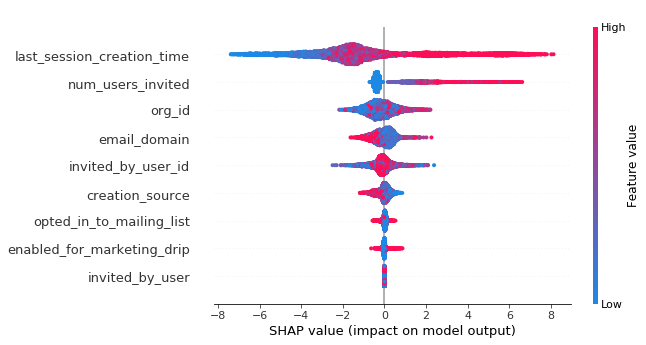

In [85]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
fig = shap.summary_plot(shap_values, X, show=False)
plt.savefig('shap_summary.png')
fig

{0: 'GUEST_INVITE',
 1: 'ORG_INVITE',
 2: 'PERSONAL_PROJECTS',
 3: 'SIGNUP',
 4: 'SIGNUP_GOOGLE_AUTH'}


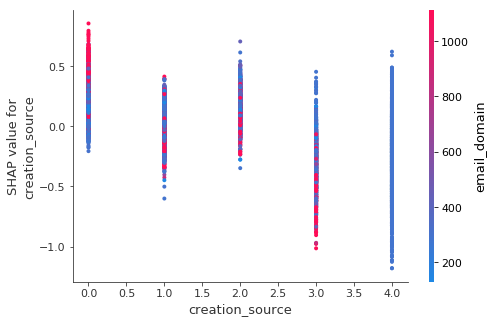

In [86]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
pprint.pprint(creation_source_map)
shap.dependence_plot("creation_source", shap_values, X)

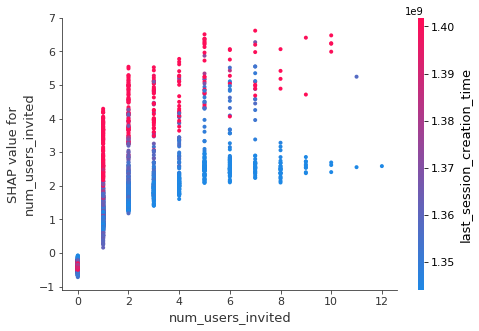

In [87]:
shap.dependence_plot("num_users_invited", shap_values, X)